In [2]:

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression

from torch import nn,optim,save
import torch

from datetime import datetime, timedelta

from sklearn.model_selection import  ShuffleSplit


from sksurv.ensemble import RandomSurvivalForest

from collections import Counter
import pickle


In [3]:
# dati clinici che abbiamo:
radiomic_raw = pd.read_csv("radiomic_features.csv", index_col=0)
clinical_raw = pd.read_csv("ClinicalData.csv", index_col=0)
RNA_seq = pd.read_csv("RNAseq_norm.csv",index_col=0)


pd.set_option("display.max_columns",None)
radiomic_raw.describe()

,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Image-original_Maximum,diagnostics_Mask-original_VoxelNum,diagnostics_Mask-original_VolumeNum,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Mean,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RobustMeanAbsoluteDeviation,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_TotalEnergy,original_firstorder_Uniformity,original_firstorder_Variance,original_glcm_Autocorrelation,original_glcm_JointAverage,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceAverage,original_glcm_DifferenceEntropy,original_glcm_DifferenceVariance,original_glcm_JointEnergy,original_glcm_JointEntropy,original_glcm_Imc1,original_glcm_Imc2,original_glcm_Idm,original_glcm_Idmn,original_glcm_Id,original_glcm_Idn,original_glcm_InverseVariance,original_glcm_MaximumProbability,original_glcm_SumEntropy,original_glcm_SumSquares,original_glrlm_GrayLevelNonUniformity,original_glrlm_GrayLevelNonUniformityNormalized,original_glrlm_GrayLevelVariance,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_LongRunEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_RunEntropy,original_glrlm_RunLengthNonUniformity,original_glrlm_RunLengthNonUniformityNormalized,original_glrlm_RunPercentage,original_glrlm_RunVariance,original_glrlm_ShortRunEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glszm_GrayLevelNonUniformity,original_glszm_GrayLevelNonUniformityNormalized,original_glszm_GrayLevelVariance,original_glszm_HighGrayLevelZoneEmphasis,original_glszm_LargeAreaEmphasis,original_glszm_LargeAreaHighGrayLevelEmphasis,original_glszm_LargeAreaLowGrayLevelEmphasis,original_glszm_LowGrayLevelZoneEmphasis,original_glszm_SizeZoneNonUniformity,original_glszm_SizeZoneNonUniformityNormalized,original_glszm_SmallAreaEmphasis,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_gldm_DependenceEntropy,original_gldm_DependenceNonUniformity,original_gldm_DependenceNonUniformityNormalized,original_gldm_DependenceVariance,original_gldm_GrayLevelNonUniformity,original_gldm_GrayLevelVariance,original_gldm_HighGrayLevelEmphasis,original_gldm_LargeDependenceEmphasis,original_gldm_LargeDependenceHighGrayLevelEmphasis,original_gldm_LargeDependenceLowGrayLevelEmphasis,original_gldm_LowGrayLevelEmphasis,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis
count,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,1.440000e+02,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,1.440000e+02,144.000000,144.000000,144.000000,144.000000,1.440000e+02,144.000000,144.0

In [4]:
#filter low variance RNAs

RNA_low_variance_mask = RNA_seq.T.var() > RNA_seq.T.var().quantile(0.05)

RNA_filtered = RNA_seq[RNA_low_variance_mask]

print(RNA_filtered.shape)

(5004, 130)


In [5]:
# mi recupero il train-test-split che ho fatto sul dataset delle CT
with open('split_dictionary.pkl', 'rb') as f:
    split_dict = pickle.load(f)

print(split_dict)

train_set = [x[:7] for x in split_dict["train"]]
val_set = [x[:7] for x in split_dict["val"]]
test_set = [x[:7] for x in split_dict["test"]]

all_set = train_set+val_set+test_set

{'train': ['R01-059_CT.npy', 'R01-086_CT.npy', 'R01-095_CT.npy', 'R01-053_CT.npy', 'R01-112_CT.npy', 'R01-013_CT.npy', 'R01-141_CT.npy', 'R01-102_CT.npy', 'R01-066_CT.npy', 'R01-061_CT.npy', 'R01-034_CT.npy', 'R01-139_CT.npy', 'R01-060_CT.npy', 'R01-145_CT.npy', 'R01-019_CT.npy', 'R01-070_CT.npy', 'R01-099_CT.npy', 'R01-133_CT.npy', 'R01-047_CT.npy', 'R01-038_CT.npy', 'R01-123_CT.npy', 'R01-128_CT.npy', 'R01-045_CT.npy', 'R01-021_CT.npy', 'R01-117_CT.npy', 'R01-077_CT.npy', 'R01-031_CT.npy', 'R01-111_CT.npy', 'R01-043_CT.npy', 'R01-008_CT.npy', 'R01-035_CT.npy', 'R01-065_CT.npy', 'R01-135_CT.npy', 'R01-017_CT.npy', 'R01-104_CT.npy', 'R01-130_CT.npy', 'R01-122_CT.npy', 'R01-084_CT.npy', 'R01-079_CT.npy', 'R01-118_CT.npy', 'R01-073_CT.npy', 'R01-109_CT.npy', 'R01-092_CT.npy', 'R01-142_CT.npy', 'R01-144_CT.npy', 'R01-068_CT.npy', 'R01-088_CT.npy', 'R01-076_CT.npy', 'R01-129_CT.npy', 'R01-087_CT.npy', 'R01-108_CT.npy', 'R01-058_CT.npy', 'R01-138_CT.npy', 'R01-089_CT.npy', 'R01-094_CT.npy',

In [4]:
print(len(train_set))
print(len(val_set))
print(len(test_set))

print(train_set)

print(pd.Series(train_set).unique().tolist())

96
17
17
['R01-059', 'R01-086', 'R01-095', 'R01-053', 'R01-112', 'R01-013', 'R01-141', 'R01-102', 'R01-066', 'R01-061', 'R01-034', 'R01-139', 'R01-060', 'R01-145', 'R01-019', 'R01-070', 'R01-099', 'R01-133', 'R01-047', 'R01-038', 'R01-123', 'R01-128', 'R01-045', 'R01-021', 'R01-117', 'R01-077', 'R01-031', 'R01-111', 'R01-043', 'R01-008', 'R01-035', 'R01-065', 'R01-135', 'R01-017', 'R01-104', 'R01-130', 'R01-122', 'R01-084', 'R01-079', 'R01-118', 'R01-073', 'R01-109', 'R01-092', 'R01-142', 'R01-144', 'R01-068', 'R01-088', 'R01-076', 'R01-129', 'R01-087', 'R01-108', 'R01-058', 'R01-138', 'R01-089', 'R01-094', 'R01-127', 'R01-063', 'R01-054', 'R01-132', 'R01-002', 'R01-082', 'R01-040', 'R01-005', 'R01-042', 'R01-121', 'R01-134', 'R01-107', 'R01-120', 'R01-115', 'R01-146', 'R01-039', 'R01-091', 'R01-103', 'R01-140', 'R01-032', 'R01-126', 'R01-080', 'R01-136', 'R01-011', 'R01-014', 'R01-020', 'R01-026', 'R01-029', 'R01-044', 'R01-048', 'R01-049', 'R01-050', 'R01-051', 'R01-052', 'R01-056', 

In [6]:
#aggiungo al dataset dei dati clinici una colonna che indica il numero di giorni che il paziente è sopravvissuto dal giorno della CT



def cambia_date(x):
    return datetime.strptime(x,"%m/%d/%Y")

survival_list = list()
clinical_temp = clinical_raw.copy()

for sample in clinical_raw.iterrows():

    date_last = cambia_date(sample[1]["Date of Last Known Alive"])
    date_CT = cambia_date(sample[1]["CT Date"])
    days_CT_surgery = timedelta(days=sample[1]["Days between CT and surgery"])

    if date_last - date_CT > days_CT_surgery: # caso in cui hanno fatto surgery dopo della CT
        delta = date_last - date_CT - days_CT_surgery
    else: # caso in cui hanno fatto surgery prima della CT
        delta = date_last - date_CT + days_CT_surgery

    survival_list.append(delta.days)

clinical_temp["Days Survived"] = survival_list


In [7]:
#Rimuovo samples con alcuni dati "Not Collected" e metto Pack Years == 0 per i non fumatori 
clinical_data = clinical_temp[clinical_temp["Pack Years"] != "Not Collected"]
clinical_data = clinical_data[clinical_data["Pathological T stage"] != "Not Collected"]
clinical_data = clinical_data[clinical_data["Pathological N stage"] != "Not Collected"]
clinical_data = clinical_data[clinical_data["Pathological M stage"] != "Not Collected"]
clinical_data = clinical_data[clinical_data["Weight (lbs)"] != "Not Collected"]
clinical_data = clinical_data[clinical_data["Chemotherapy"] != "Not Collected"]
clinical_data = clinical_data[clinical_data["Radiation"] != "Not Collected"]
clinical_data = clinical_data[clinical_data["Recurrence"] != "Not Collected"]
clinical_data["Pack Years"] = clinical_data["Pack Years"].fillna(0)

clinical_data

,Patient affiliation,Age at Histological Diagnosis,Weight (lbs),Gender,Ethnicity,Smoking status,Pack Years,Quit Smoking Year,%GG,Tumor Location (choice=RUL),Tumor Location (choice=RML),Tumor Location (choice=RLL),Tumor Location (choice=LUL),Tumor Location (choice=LLL),Tumor Location (choice=L Lingula),Tumor Location (choice=Unknown),Histology,Pathological T stage,Pathological N stage,Pathological M stage,Histopathological Grade,Lymphovascular invasion,"Pleural invasion (elastic, visceral, or parietal)",EGFR mutation status,KRAS mutation status,ALK translocation status,Adjuvant Treatment,Chemotherapy,Radiation,Recurrence,Recurrence Location,Date of Recurrence,Date of Last Known Alive,Survival Status,Date of Death,Time to Death (days),CT Date,Days between CT and surgery,PET Date,Days Survived
Case ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
R01-001,Stanford,79,146,Female,Caucasian,Former,37,1967.0,0%,Checked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Adenocarcinoma,T1a,N0,M0,G2 Moderately differentiated,Absent,No,Unknown,Unknown,Unknown,No,No,No,no,NaN,NaN,2/9/1999,Alive,NaN,NaN,9/6/1990,42,10/17/1990,3036
R01-002,Stanford,65,195,Female,Asian,Nonsmoker,0,NaN,0%,Checked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Adenocarcinoma,T1a,N0,M0,G1 Well differentiated,Absent,No,Unknown,Unknown,Unknown,No,No,No,no,NaN,NaN,11/29/1990,Alive,NaN,NaN,9/20/1990,23,10/11/1990,47
R01-005,Stanford,84,145,Male,Native Hawaiian/Pacific Islander,Former,20,1951.0,0%,Unchecked,Checked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Adenocarcinoma,T2a,N0,M0,G3 Poorly differentiated,Absent,No,Wildtype,Unknown,Wildtype,No,No,No,yes,distant,1/19/1993,6/3/1995,Dead,6/3/1995,1456.0,3/8/1991,92,4/19/1991,1456
R01-008,Stanford,73,102,Male,Caucasian,Nonsmoker,0,NaN,>0 - 25%,Checked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Adenocarcinoma,Tis,N0,M0,G1 Well differentiated,Absent,No,Wildtype,Mutant,Unknown,No,No,No,no,NaN,NaN,8/8/1997,Alive,NaN,NaN,4/24/1991,34,5/11/1991,2264
R01-009,VA,59,133,Male,Caucasian,Current,100,NaN,0%,Unchecked,Checked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Adenocarcinoma,T1a,N0,M0,G3 Poorly differentiated,Absent,No,Wildtype,Wildtype,Wildtype,No,No,No,no,NaN,NaN,9/28/1994,Dead,9/28/1994,1344.0,11/25/1990,59,12/8/1990,1344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R01-158,Stanford,67,143,Male,Hispanic/Latino,Current,25,NaN,Not Assessed,Checked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Squamous cell carcinoma,T2a,N1,M0,G2 Moderately differentiated,Absent,No,Unknown,Unknown,Unknown,Yes,Yes,No,no,NaN,NaN,9/30/1995,Alive,NaN,NaN,10/6/1994,5,8/19/1994,354
R01-159,Stanford,75,184,Male,Caucasian,Former,55,1994.0,Not Assessed,Unchecked,Unchecked,Unchecked,Unchecked,Checked,Unchecked,Unchecked,Squamous cell carcinoma,T2a,N1,M0,G2 Moderately differentiated,Absent,No,Unknown,Unknown,Unknown,No,No,No,no,NaN,NaN,7/13/1995,Alive,NaN,NaN,11/24/1994,14,11/16/1994,217
R01-160,VA,61,231.5,Male,Caucasian,Former,12,1993.0,Not Assessed,Checked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Adenocarcinoma,T3,N0,M0,"Other, Type II: Moderately to poorly different...",Absent,No,Unknown,Mutant,Unknown,Yes,Yes,No,no,NaN,NaN,7/3/1999,Alive,NaN,NaN,8/12/1993,72,9/22/1993,2079


In [8]:
radiomic_columns = [x for x in radiomic_raw.columns if x.startswith("diagnostics")==False]
print(len(radiomic_columns))

radiomic_data = radiomic_raw[radiomic_columns]

radiomic_data/radiomic_data.mean()

100


,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Mean,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RobustMeanAbsoluteDeviation,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_TotalEnergy,original_firstorder_Uniformity,original_firstorder_Variance,original_glcm_Autocorrelation,original_glcm_JointAverage,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceAverage,original_glcm_DifferenceEntropy,original_glcm_DifferenceVariance,original_glcm_JointEnergy,original_glcm_JointEntropy,original_glcm_Imc1,original_glcm_Imc2,original_glcm_Idm,original_glcm_Idmn,original_glcm_Id,original_glcm_Idn,original_glcm_InverseVariance,original_glcm_MaximumProbability,original_glcm_SumEntropy,original_glcm_SumSquares,original_glrlm_GrayLevelNonUniformity,original_glrlm_GrayLevelNonUniformityNormalized,original_glrlm_GrayLevelVariance,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_LongRunEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_RunEntropy,original_glrlm_RunLengthNonUniformity,original_glrlm_RunLengthNonUniformityNormalized,original_glrlm_RunPercentage,original_glrlm_RunVariance,original_glrlm_ShortRunEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glszm_GrayLevelNonUniformity,original_glszm_GrayLevelNonUniformityNormalized,original_glszm_GrayLevelVariance,original_glszm_HighGrayLevelZoneEmphasis,original_glszm_LargeAreaEmphasis,original_glszm_LargeAreaHighGrayLevelEmphasis,original_glszm_LargeAreaLowGrayLevelEmphasis,original_glszm_LowGrayLevelZoneEmphasis,original_glszm_SizeZoneNonUniformity,original_glszm_SizeZoneNonUniformityNormalized,original_glszm_SmallAreaEmphasis,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_gldm_DependenceEntropy,original_gldm_DependenceNonUniformity,original_gldm_DependenceNonUniformityNormalized,original_gldm_DependenceVariance,original_gldm_GrayLevelNonUniformity,original_gldm_GrayLevelVariance,original_gldm_HighGrayLevelEmphasis,original_gldm_LargeDependenceEmphasis,original_gldm_LargeDependenceHighGrayLevelEmphasis,original_gldm_LargeDependenceLowGrayLevelEmphasis,original_gldm_LowGrayLevelEmphasis,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis
R01-001,0.891635,0.795176,0.410050,0.504485,0.464677,0.502434,0.409968,0.451920,0.047469,0.458424,1.112626,0.130029,1.555350,0.048201,1.857532,0.998306,0.077159,0.889990,0.608763,0.923793,0.747172,0.647982,1.218267,1.260354,7.242705,0.624297,0.628034,1.137297,2.177938,0.049100,1.413772,0.404524,0.862154,0.979986,0.144622,0.576328,0.328422,0.356073,0.980431,0.614200,0.871259,0.378263,1.915043,0.850579,0.969019,0.981076,1.413650,1.004657,1.280990,1.006967,1.372822,1.925567,0.873832,0.333261,0.072538,1.321585,0.420456,0.810517,1.108462,0.927277,0.138556,0.171937,0.929687,0.073717,0.940517,0.960181,1.443844,0.975978,0.780049,0.180740,0.1

In [9]:
# rifaccio la stessa cosa ma senza il dato CD8, per vedere se migliora o peggiora le previsioni

clinical_dummy = pd.get_dummies(clinical_data[["Age at Histological Diagnosis","Weight (lbs)","Gender","Smoking status","Pack Years","Chemotherapy","Radiation","Recurrence","Survival Status","Days Survived", "Pathological T stage", "Pathological N stage", "Pathological M stage"]], columns=["Smoking status", "Pathological T stage", "Pathological N stage", "Pathological M stage"])
#clinical_dummy = clinical_data[["Age at Histological Diagnosis","Weight (lbs)","Gender","Smoking status","Pack Years","Chemotherapy","Radiation","Recurrence","Survival Status","Days Survived", "Pathological T stage", "Pathological N stage", "Pathological M stage"]]

for x in ["Gender", "Survival Status","Chemotherapy","Radiation","Recurrence"]:
    factorized = pd.factorize(clinical_dummy[x])
    clinical_dummy[x] = factorized[0]
    print(x, factorized[1])

train_index = [x for x in train_set if x in clinical_dummy.index]
val_index = [x for x in val_set if x in clinical_dummy.index]
test_index = [x for x in test_set if x in clinical_dummy.index]

all_index = train_index + val_index + test_index

clinical_noCT = clinical_dummy[~clinical_dummy.index.isin(all_index)]

print(clinical_noCT.shape)

clinical_train = pd.concat([clinical_dummy.loc[train_index,:],clinical_noCT]).astype(float)
clinical_val = clinical_dummy.loc[val_index,:].astype(float)
clinical_test = clinical_dummy.loc[test_index,:].astype(float)


print(clinical_train.shape, clinical_val.shape, clinical_test.shape)



Gender Index(['Female', 'Male'], dtype='object')
Survival Status Index(['Alive', 'Dead'], dtype='object')
Chemotherapy Index(['No', 'Yes'], dtype='object')
Radiation Index(['No', 'Yes'], dtype='object')
Recurrence Index(['no', 'yes'], dtype='object')
(17, 25)
(113, 25) (17, 25) (17, 25)


In [14]:

new_train_index = [x for x in train_set if x in radiomic_data.index and x in RNA_filtered.columns ]
new_val_index = [x for x in val_set if x in radiomic_data.index and x in RNA_filtered.columns]
new_test_index = [x for x in test_set if x in radiomic_data.index and x in RNA_filtered.columns]

new_all_index = new_train_index + new_val_index + new_test_index

new_radiomic_noCT = radiomic_data[~radiomic_data.index.isin(new_all_index)]

print(new_radiomic_noCT.shape)

new_radiomic_train = pd.concat([radiomic_data.loc[new_train_index,:],new_radiomic_noCT]).astype(float)
new_radiomic_val = radiomic_data.loc[new_val_index,:].astype(float)
new_radiomic_test = radiomic_data.loc[new_test_index,:].astype(float)

radiomic_train_means = new_radiomic_train.mean()

radiomic_train_means.to_csv("radiomic_train_means.csv")

print(new_radiomic_train.shape, new_radiomic_val.shape, new_radiomic_test.shape)


(38, 100)
(114, 100) (14, 100) (16, 100)


In [17]:
x_train_radiomic = new_radiomic_train/radiomic_train_means
x_train_clinical = clinical_train.drop(["Survival Status", "Days Survived"], axis=1)
x_train_RNA = RNA_filtered.T.loc[new_train_index,:].astype(float)

common_index = x_train_clinical.index.intersection(x_train_radiomic.index).intersection(x_train_RNA.index)

X_train = pd.concat([x_train_radiomic.loc[common_index,:], x_train_clinical.loc[common_index,:], x_train_RNA.loc[common_index,:]], axis=1)

Y_train = clinical_data.loc[common_index,["Survival Status","Days Survived"]]

Y_train["Survival Status"] = Y_train["Survival Status"].apply(lambda x: x=="Dead")
Y_train["Days Survived"] = Y_train["Days Survived"].apply(lambda x: int(x))

y_train = Y_train.to_records(index=False)

print(X_train.shape)
print(y_train)

(76,)
(76, 5127)
[(False, 2054) ( True,  417) (False, 3388) (False, 1161) (False,  344)
 ( True,  201) (False, 2048) (False, 2525) (False, 1259) (False, 2084)
 (False,  753) ( True,  952) ( True,  600) (False,  124) (False, 1370)
 ( True,  328) (False, 2139) ( True, 1083) ( True, 1322) ( True, 1890)
 (False, 1558) (False, 1784) ( True, 1798) ( True,  346) (False,   20)
 ( True,  474) (False, 1456) (False,  197) (False,  558) (False,  767)
 (False, 1363) (False, 1473) (False, 1933) (False, 1784) (False, 1132)
 (False,  986) (False, 1953) (False, 1881) (False,   49) (False, 1741)
 ( True,   14) (False, 1726) (False, 1770) (False, 1399) (False, 1931)
 (False, 2114) (False, 1230) ( True, 2041) ( True, 1456) ( True,   42)
 (False, 1208) (False,   16) (False, 1461) (False, 1410) (False, 1553)
 ( True,  276) ( True,   41) ( True,  985) ( True,  210) (False,  112)
 (False, 2553) (False, 1477) (False, 1927) (False, 1126) (False, 1907)
 ( True, 2356) ( True,  286) (False, 2246) (False, 1950) ( T

In [18]:
x_val_radiomic = new_radiomic_val/radiomic_train_means
x_val_clinical = clinical_val.drop(["Survival Status", "Days Survived"], axis=1)
x_val_RNA = RNA_filtered.T.loc[new_val_index,:].astype(float)

common_index = x_val_clinical.index.intersection(x_val_radiomic.index).intersection(x_val_RNA.index)

X_val = pd.concat([x_val_radiomic.loc[common_index,:], x_val_clinical.loc[common_index,:], x_val_RNA.loc[common_index,:]], axis=1)

Y_val = clinical_data.loc[common_index,["Survival Status","Days Survived"]]

Y_val["Survival Status"] = Y_val["Survival Status"].apply(lambda x: x=="Dead")
Y_val["Days Survived"] = Y_val["Days Survived"].apply(lambda x: int(x))

y_val = Y_val.to_records(index=False)

print(X_val.shape)
print(y_val)

(14, 5127)
[(False, 1993) (False, 1715) (False, 3059) (False, 1800) ( True, 1491)
 (False, 2161) (False, 2117) (False, 2184) ( True, 1425) ( True,  225)
 ( True,  867) (False, 1259) ( True,   28) ( True,  280)]


In [19]:


p_splits = range(2,12)

p_leaves = range(1,9)

n_trees = 100

rng = 42

sss = ShuffleSplit(n_splits=10, test_size=0.25, random_state=rng) 

splits = sss.split(X_train, Y_train)

results = np.zeros(shape=(len(p_splits), len(p_leaves), sss.get_n_splits()))

for k, s in enumerate(splits):
    print("k",k)
    for j, l in enumerate(p_leaves):
        print("j",j)
        for i, p in enumerate(p_splits):
            print("i", i)
            
            x_t = X_train.iloc[s[0].tolist(),:]
            y_t = y_train[s[0]]

            x_v = X_train.iloc[s[1].tolist(),:]
            y_v = y_train[s[1]]

            rsf = RandomSurvivalForest(
                n_estimators=n_trees, min_samples_split=p, min_samples_leaf=l, n_jobs=-1, random_state=rng)

            rsf.fit(x_t, y_t)

            cv_score = rsf.score(x_v, y_v)
            results[i,j,k] = cv_score


k 0
j 0
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
j 1
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
j 2
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
j 3
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
j 4
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
j 5
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
j 6
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
j 7
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
k 1
j 0
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
j 1
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
j 2
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
j 3
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
j 4
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
j 5
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
j 6
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
j 7
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
k 2
j 0
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
j 1
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
j 2
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
j 3
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
j 4
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
j 5
i 0
i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
j 6
i 0
i 1
i 2
i 3


2 3
0.611708954317309


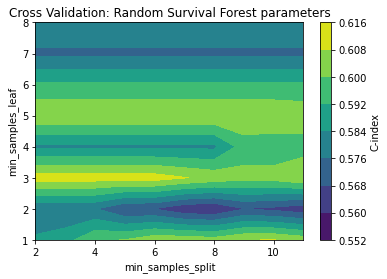

In [21]:
mean_results = results.mean(axis=2)

plt.contourf(p_splits, p_leaves, mean_results.T)
plt.title("Cross Validation: Random Survival Forest parameters")
plt.xlabel("min_samples_split")
plt.ylabel("min_samples_leaf")
cb = plt.colorbar()
cb.set_label("C-index")
plt.savefig("clinical_radiomic_rna_cv.png", dpi=300)

best_val_index = np.unravel_index(np.argmax(mean_results), mean_results.shape)
print(p_splits[best_val_index[0]], p_leaves[best_val_index[1]])
print(mean_results[best_val_index])

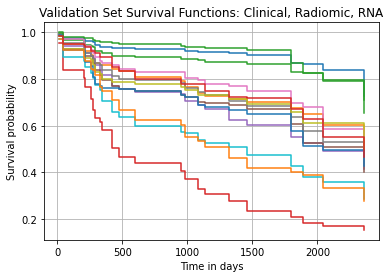

In [24]:
random_state = 42

rsf = RandomSurvivalForest(
    n_estimators=n_trees,
    min_samples_split=p_splits[best_val_index[0]],
    min_samples_leaf=p_leaves[best_val_index[1]],
    n_jobs=-1,
    random_state=random_state
)

rsf.fit(X_train, y_train)

train_surv = rsf.predict_survival_function(X_train, return_array=True)
val_surv = rsf.predict_survival_function(X_val, return_array=True)

for i, s in enumerate(val_surv):
    plt.step(rsf.event_times_, s, where="post", label=str(i))

plt.title("Validation Set Survival Functions: Clinical, Radiomic, RNA")
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.grid(True)

plt.savefig("clinical_radiomic_rna_sf.png", dpi=300)

In [25]:
print(rsf.score(X_train, y_train))
print(rsf.score(X_val, y_val))

0.9733218588640276
0.5409836065573771


In [26]:
def Monte_Carlo(event_times, survs, n_simulations):

    outputs = list()

    #print(f"{0:.1f}",f"{1:.3f}", n_simulations)

    for event_probs in survs:
        event_probs.tolist().insert(0,1)
        output = []
        temp_survivors = n_simulations
        cnt = 0
        while cnt < len(event_probs)-1:
            x_array = np.random.uniform(size=temp_survivors) >= event_probs[cnt+1]/event_probs[cnt]
            n_deaths = x_array.sum()
            temp_survivors -= n_deaths
            #print(t, f"{event_probs[i]:.3f}", temp_survivors)
            output.extend([event_times[cnt]]*n_deaths)
            cnt += 1
        output.extend([event_times[-1]+1]*temp_survivors)

        outputs.append(np.array(output).mean())
    return outputs

In [27]:
train_expected = clinical_data.loc[X_train.index.tolist(),"Days Survived"].tolist()
train_predicted = Monte_Carlo(rsf.event_times_, train_surv, 100000)
val_expected = clinical_data.loc[X_val.index.tolist(),"Days Survived"].tolist()
val_predicted = Monte_Carlo(rsf.event_times_, val_surv, 100000)

print(train_predicted)

[2208.07611, 695.4294, 2169.5832, 1728.59133, 1511.34403, 1175.83351, 2136.72354, 2206.44522, 1933.31346, 2003.6026, 1891.3278, 1017.68941, 935.76863, 1849.81077, 1991.30956, 889.80549, 1998.78563, 1151.01738, 1197.61693, 1575.64521, 1938.44381, 1913.09464, 1553.52095, 887.52957, 993.95965, 1214.15371, 1951.49861, 1483.34362, 1586.89334, 1678.59885, 1776.29558, 1849.37565, 1778.02887, 1912.18945, 1844.87649, 1882.27417, 1990.7667, 2178.40665, 1305.09638, 1742.92856, 801.82038, 1868.09218, 2041.38756, 1926.46822, 2089.51497, 1883.75784, 1939.86941, 1672.76001, 1288.73538, 934.49577, 1791.10752, 1220.26215, 1863.32632, 1851.74298, 1995.49318, 748.83596, 858.50284, 1517.67421, 575.6095, 1429.24798, 2155.06741, 1954.90992, 2244.34012, 1914.86961, 2175.84271, 1926.36718, 743.0798, 2012.02327, 2040.00786, 663.95078, 2003.55221, 2109.50076, 1984.45565, 1199.10785, 2227.50617, 1954.27366]


In [28]:
train_regressor = LinearRegression()

train_regressor.fit(X = np.array(train_expected).reshape(-1,1), y= np.array(train_predicted).reshape(-1,1))

train_y = train_regressor.predict(np.arange(3500).reshape(-1,1))

val_regressor = LinearRegression()

val_regressor.fit(X = np.array(val_expected).reshape(-1,1), y= np.array(val_predicted).reshape(-1,1))

val_y = val_regressor.predict(np.arange(3500).reshape(-1,1))


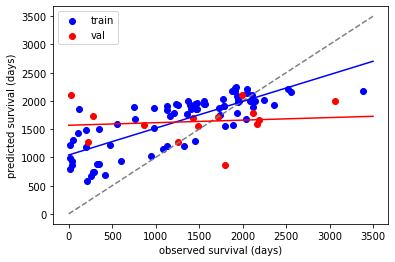

In [29]:
#blue: train
#red: val

plt.scatter(train_expected, train_predicted, c="blue")
plt.scatter(val_expected, val_predicted, c="red")

mae = nn.L1Loss()

train_loss = mae(torch.Tensor(train_expected), torch.Tensor(train_predicted))
val_loss = mae(torch.Tensor(val_expected), torch.Tensor(val_predicted))

plt.plot(range(3500), range(3500), "--", c = "gray")
plt.plot(range(3500), train_y, c="blue")
plt.plot(range(3500), val_y, c="red")

plt.xlabel("observed survival (days)")
plt.ylabel("predicted survival (days)")

plt.legend(["train","val"])
plt.savefig("clinical_radiomic_rna.png", dpi=300)

In [30]:
print(train_regressor.coef_)
print(train_regressor.intercept_)

print(val_regressor.coef_)
print(val_regressor.intercept_)

print("")
# print(np.sqrt(train_loss))
# print(np.sqrt(val_loss))
print(train_loss)
print(val_loss)



[[0.47408135]]
[1043.06464962]
[[0.04540867]]
[1569.15483275]

tensor(490.1259)
tensor(653.8135)
